In [1]:
import pybullet as p
import numpy as np
import sys
import os
import json
import open3d as o3d
import matplotlib.pyplot as plt

sys.path.append("../")
from env.ycb_scene import SimulatedYCBEnv
from utils.grasp_checker import ValidGraspChecker
from utils.utils import *

pybullet build time: Dec  1 2021 18:33:43


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
'''
get data file name in json file and load mesh in pybullet
then reset robot and object position
'''

file = os.path.join("../object_index", 'ycb_large.json')
with open(file) as f: file_dir = json.load(f)
file_dir = file_dir['test']
file_dir = [f[:-5].split('.')[0][:-2] for f in file_dir]
test_file_dir = list(set(file_dir))

env = SimulatedYCBEnv()
env._load_index_objs(test_file_dir)
state = env.reset(save=False, enforce_face_target=True)

/home/ros/Downloads/TM5_900_pybullet/env/models
>>>> target name: 003_cracker_box


In [3]:
def scenes_check():
    for uid in np.array(env._objectUids)[np.array(env.placed_objects)]:
        if p.getBasePositionAndOrientation(uid)[0][2] < env.table_pos[2]:
            return False
    if not env.stack_success:
        return False
    return True

In [4]:
# How many times to reset scene if object reset failed
reset_times = 5
# Number of object put on table
num_object = 5
# If object in table scene be uniformly placed
stack = True

# Reset environment without reload object mesh, set "reset_free=True"
for _ in range(reset_times):
    state = env.reset(save=False, reset_free=True, num_object=num_object, if_stack=stack)
    if not scenes_check():
        state = env.reset(save=False, reset_free=True, num_object=num_object, if_stack=stack)
    else:
        break

>>>> target name: 061_foam_brick
>>>> target name: 025_mug
>>>> target name: 004_sugar_box
>>>> target name: 010_potted_meat_can
>>>> target name: 024_bowl


In [5]:
placed_obj = {}
placed_idx = np.where(np.array(env.placed_objects))[0]
placed_name = np.array(env.obj_indexes)[np.where(np.array(env.placed_objects))]
for i in range(num_object):
    placed_obj[placed_idx[i]] = placed_name[i]
print(placed_obj)

{0: '004_sugar_box', 3: '025_mug', 4: '061_foam_brick', 6: '010_potted_meat_can', 7: '024_bowl'}


## Valid Grasp Pose Checker
This API will take input as grasping pose group and validate collision between gripper and target object. It uses pybullet API to test if the gripper mesh has contact points with current environment when the gripper is set to fully opened.

In [6]:
'''
When user declare a checker, it will load a additional robot gripper at world origin.
Do NOT re-declare ValidGraspChecker.
'''

grasp_checker = ValidGraspChecker(env)

In [7]:
'''
Take pre-define grasp dataset of target object as an example.
Load npy file by object names.
'''

obj_name = env.obj_path[env.target_idx].split('/')[-2]
tr = np.load(f'/home/ros/GA-DDPG/data/grasps/simulated/{obj_name}.npy',
            allow_pickle=True,
            fix_imports=True,
            encoding="bytes")
grasp = tr.item()[b'transforms']

In [8]:
# Transforms grasp pose to current position

obj_pos = p.getBasePositionAndOrientation(env._objectUids[env.target_idx])
obj_pos_mat = unpack_pose([*obj_pos[0] , *tf_quat(obj_pos[1])])
grasp_candidate = obj_pos_mat.dot(grasp.T)
grasp_candidate = np.transpose(grasp_candidate, axes=[2, 0, 1])

In [9]:
'''
The extract_grasp() function takes grasp group[N, 4, 4] as input and outputs valid grasps.
The parameter "drawback_distance" is the distance to draw back the end effector pose along z-axis in validation process.
The parameter "filter_elbow" denote if checker use estimated elbow point and bounding box of table
    as one of the measurements to prevent collision of other joint.
Note: The estimated elbow point is NOT calculate by IK, so it's nearly a rough guess.
'''

grasp_array, grasp_index = grasp_checker.extract_grasp(grasp_candidate,
                                                       drawback_distance=0.015,
                                                       visual=False,
                                                       filter_elbow=True)
print(f"Valid index in grasp group:\n    {grasp_index}\
      \nGrasp Matrix:\n{grasp_array[0]}")

Valid index in grasp group:
    [ 4  9 10 13 23 29 33 36 40 47 50 51 54 61 69 75 80 81 90 95 96 98]      
Grasp Matrix:
[[-0.49369403 -0.86938912 -0.02070251 -0.41827973]
 [-0.8662525   0.48953612  0.0998045  -0.75911661]
 [-0.07663433  0.06720649 -0.99479157 -1.23440236]
 [ 0.          0.          0.          1.        ]]


In [10]:
# Visualize validation process by setting "visual=True"

if len(grasp_index):
    _, _ = grasp_checker.extract_grasp(grasp_array,
                                       drawback_distance=0.,
                                       visual=True)

## Get environment observation in multi-object scenario

User must specify env.target_idx before any process in robot task. The variable target_idx will effect entire environment setting and API, including image pre-processing, point cloud extraction, and object lifted detection in env.retract().

0 004_sugar_box
3 025_mug
4 061_foam_brick
6 010_potted_meat_can
7 024_bowl


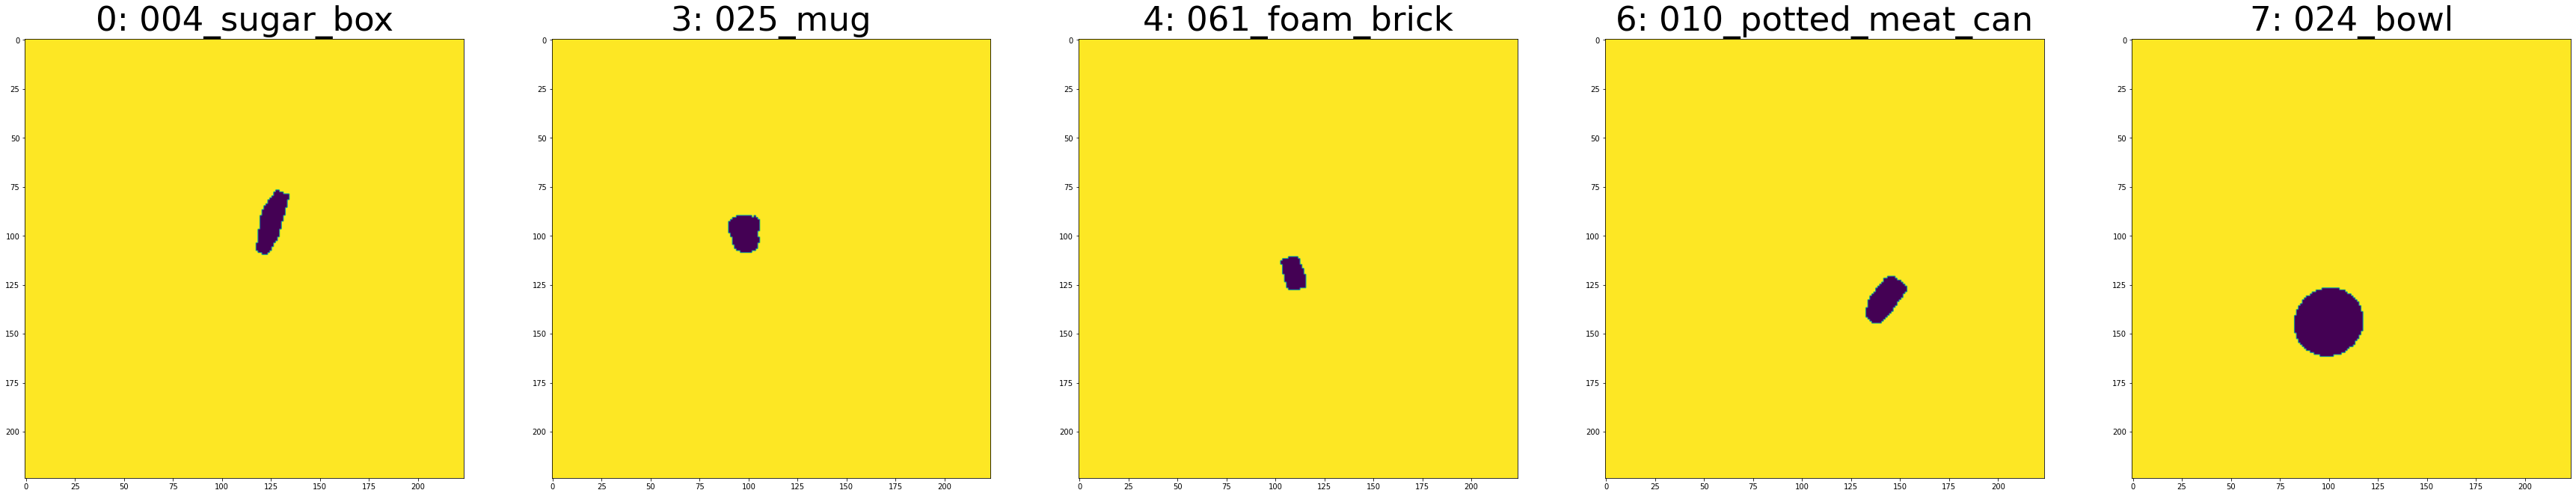

In [11]:
fig=plt.figure(figsize=(61, 61))
for i, index in enumerate(placed_obj.keys()):
    name = placed_obj[index]

    #Specify target_idx before get observation
    env.target_idx = index
    obs, _, _, _ = env._get_observation()
    fig.add_subplot(1, num_object, i+1)

    # Show image mask of each object
    plt.imshow(obs[1][4].T)
    plt.title(f"{index}: {name}", fontsize=45) 
    print(index, name)
plt.show()